<a href="https://colab.research.google.com/github/SourLemon23/brain-tumor-diagnosis/blob/master/brain_tumor_diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input, decode_predictions
import matplotlib.pyplot as plt

In [41]:
# Initialize dataset directories (Google Drive)
training_dir   = r'/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/training'
validation_dir = r'/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/validation'
testing_dir    = r'/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing'

test_img_paths = []

for root, dirs, files in os.walk(testing_dir):
    for filename in files:
        test_img_paths.append(os.path.abspath(os.path.join(root, filename)))

In [42]:
# Initialize constants
classes = ['glioma', 'meningioma', 'normal', 'pituitary']
num_classes = 4
img_width, img_height = 150, 150
target_size = (img_width, img_height)
input_shape = (img_width, img_height, 3)

training_samples = 2870
validation_samples = 202
batch_size = 20
epochs = 5

In [43]:
# Augment data
training_data_gen = ImageDataGenerator(rescale=1./255,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True)

validation_data_gen = ImageDataGenerator(rescale=1./255)

In [44]:
# Split data
train_generator = training_data_gen.flow_from_directory(training_dir,
                                                        target_size=target_size,
                                                        class_mode='categorical',
                                                        batch_size=batch_size,
                                                        shuffle=True)

validation_generator = validation_data_gen.flow_from_directory(validation_dir,
                                                               target_size=target_size,
                                                               class_mode='categorical',
                                                               batch_size=batch_size,
                                                               shuffle=False)

Found 2870 images belonging to 4 classes.
Found 202 images belonging to 4 classes.


In [45]:
# Create a neural network
def create_model():
    model = Sequential()

    model.add(ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape = input_shape))
    model.add(Dropout(0.5))

    model.add(Conv2D(16, (3, 3), activation = 'relu', padding='same', input_shape = input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(BatchNormalization())

    model.add(Conv2D(32, (3, 3), activation = 'relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [46]:
# Print an overall summary of the model
def print_model_summary(model):
    model.summary()

In [47]:
# Configure model
def compile_model(model):
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [48]:
# Train the model
def fit_model(model):
    history = model.fit(train_generator,
                        epochs=epochs,
                        steps_per_epoch=(training_samples/batch_size),
                        validation_data=validation_generator,
                        validation_steps=(validation_samples/batch_size))
    
    return history

In [49]:
# Plot and evaluate the model
def evaluate_model(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

In [50]:
# Classify a tumor from an MRI scan
def classify_tumor(model, img_path):
    for i, img_path in enumerate(test_img_paths):
        img = load_img(
            img_path,
            target_size=target_size)

        img_array = img_to_array(img)
        img_array = preprocess_input(img_array)
        img_array = img_array.reshape((-1, 150, 150, 3))

        predictions = model.predict(img_array)
        class_num = predictions.argmax()

        network_percent_confidence = str(np.max(predictions) * 100)[:4] + '%'
        network_prediction = classes[class_num].capitalize()

        font = {'family': 'DejaVu Sans',
                'color' : 'red',
                'weight': 'heavy',
                'size'  :  10}

        print(f'MRI Scan #{i+1})')
        plt.imshow(img)
        plt.title(f'Network Prediction: {network_prediction} ({network_percent_confidence})', fontdict=font)
        plt.show()

In [51]:
model = create_model()
compile_model(model)
print_model_summary(model)

# history = fit_model(model)
# evaluate_model(history)

# classify_tumor(model, test_img_paths)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
dropout_6 (Dropout)          (None, 5, 5, 2048)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 5, 5, 16)          294928    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 3, 3, 16)          0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 3, 3, 16)          64        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 3, 3, 32)          4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 2, 2, 32)         

Epoch 1/5
144/143 [==============================] - 34s 233ms/step - loss: 0.7958 - accuracy: 0.7153 - val_loss: 25.9814 - val_accuracy: 0.1733
Epoch 2/5
144/143 [==============================] - 32s 225ms/step - loss: 0.4826 - accuracy: 0.8310 - val_loss: 1.4205 - val_accuracy: 0.3168
Epoch 3/5
144/143 [==============================] - 33s 229ms/step - loss: 0.3673 - accuracy: 0.8718 - val_loss: 1.4093 - val_accuracy: 0.3168
Epoch 4/5
144/143 [==============================] - 33s 228ms/step - loss: 0.3086 - accuracy: 0.8948 - val_loss: 1.4009 - val_accuracy: 0.3020
Epoch 5/5
144/143 [==============================] - 32s 223ms/step - loss: 0.2834 - accuracy: 0.9031 - val_loss: 2.6927 - val_accuracy: 0.2921


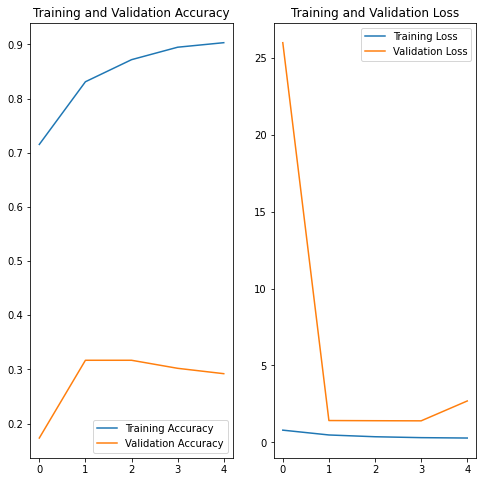

In [52]:
history = fit_model(model)
evaluate_model(history)

Predictions: [[0. 1. 0. 0.]]
MRI Scan #1)


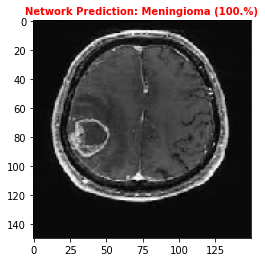

Predictions: [[0.0000000e+00 1.0000000e+00 0.0000000e+00 8.0246287e-38]]
MRI Scan #2)


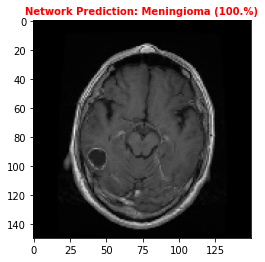

Predictions: [[0.000000e+00 1.000000e+00 0.000000e+00 2.061879e-37]]
MRI Scan #3)


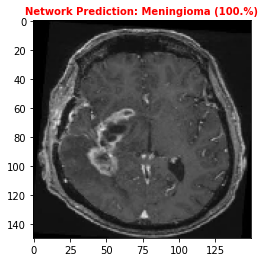

Predictions: [[0. 1. 0. 0.]]
MRI Scan #4)


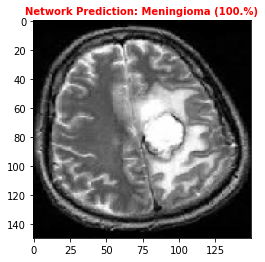

Predictions: [[0. 1. 0. 0.]]
MRI Scan #5)


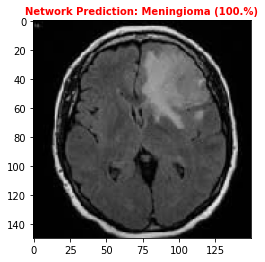

Predictions: [[0. 1. 0. 0.]]
MRI Scan #6)


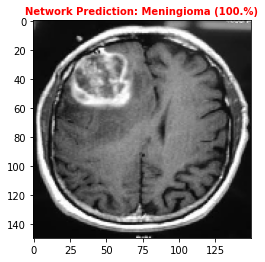

Predictions: [[0. 1. 0. 0.]]
MRI Scan #7)


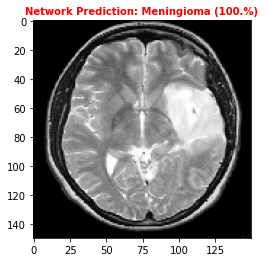

Predictions: [[3.7311158e-38 1.0000000e+00 0.0000000e+00 0.0000000e+00]]
MRI Scan #8)


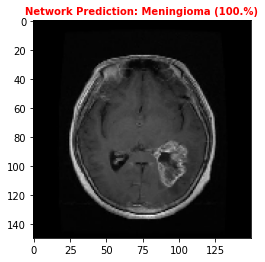

Predictions: [[0. 1. 0. 0.]]
MRI Scan #9)


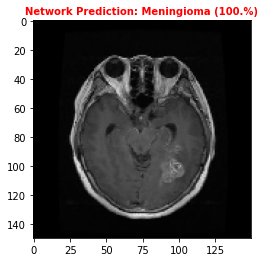

Predictions: [[0. 1. 0. 0.]]
MRI Scan #10)


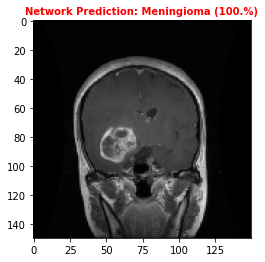

Predictions: [[0. 1. 0. 0.]]
MRI Scan #11)


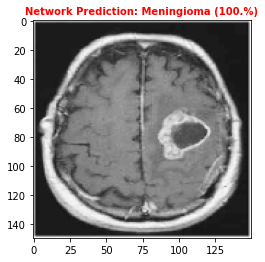

Predictions: [[0. 1. 0. 0.]]
MRI Scan #12)


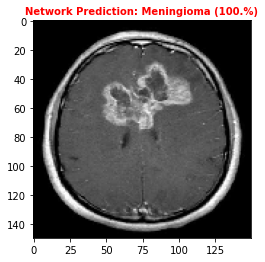

Predictions: [[1.2763155e-36 1.0000000e+00 0.0000000e+00 4.2790411e-35]]
MRI Scan #13)


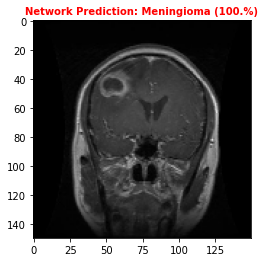

Predictions: [[4.7401387e-34 1.0000000e+00 0.0000000e+00 1.6888062e-36]]
MRI Scan #14)


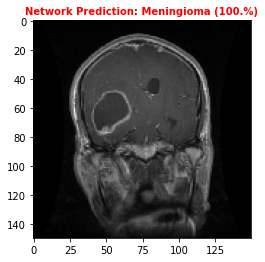

Predictions: [[4.7401387e-34 1.0000000e+00 0.0000000e+00 1.6888062e-36]]
MRI Scan #15)


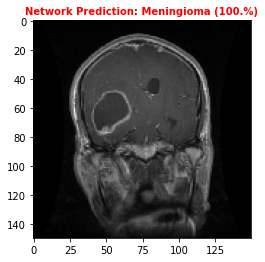

Predictions: [[0. 1. 0. 0.]]
MRI Scan #16)


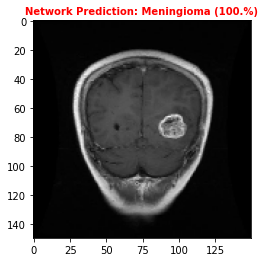

Predictions: [[0. 1. 0. 0.]]
MRI Scan #17)


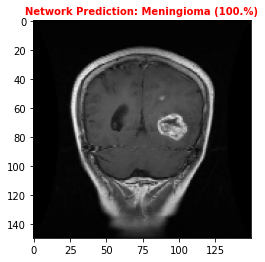

Predictions: [[2.8328491e-37 1.0000000e+00 0.0000000e+00 3.2404274e-37]]
MRI Scan #18)


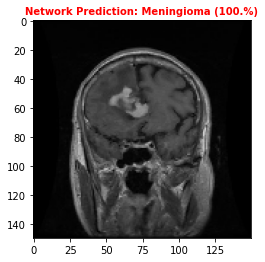

Predictions: [[2.6774551e-38 1.0000000e+00 0.0000000e+00 1.0601667e-37]]
MRI Scan #19)


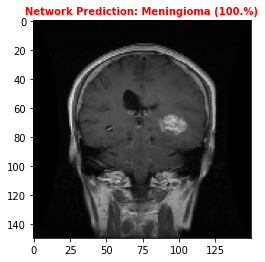

Predictions: [[2.1955282e-30 1.0000000e+00 0.0000000e+00 7.1420680e-32]]
MRI Scan #20)


KeyboardInterrupt: ignored

In [62]:
classify_tumor(model, test_img_paths)